<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li></ul></li><li><span><a href="#Load-folds" data-toc-modified-id="Load-folds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load folds</a></span><ul class="toc-item"><li><span><a href="#Incountry-folds-+-loc_dict" data-toc-modified-id="Incountry-folds-+-loc_dict-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Incountry folds + loc_dict</a></span></li><li><span><a href="#country_indices-and-country_labels" data-toc-modified-id="country_indices-and-country_labels-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span><code>country_indices</code> and <code>country_labels</code></a></span></li><li><span><a href="#OOC-folds" data-toc-modified-id="OOC-folds-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>OOC folds</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Urban v. Rural</a></span></li></ul></li><li><span><a href="#Dumb-Baseline-Models" data-toc-modified-id="Dumb-Baseline-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dumb Baseline Models</a></span><ul class="toc-item"><li><span><a href="#Incountry:-predict-country-mean" data-toc-modified-id="Incountry:-predict-country-mean-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Incountry: predict country mean</a></span></li><li><span><a href="#Linear-Nightlights" data-toc-modified-id="Linear-Nightlights-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Nightlights</a></span></li><li><span><a href="#KNN-on-Nightlights" data-toc-modified-id="KNN-on-Nightlights-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>KNN on Nightlights</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#OOC-Keep" data-toc-modified-id="OOC-Keep-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>OOC Keep</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li><li><span><a href="#GBT-on-NL" data-toc-modified-id="GBT-on-NL-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>GBT on NL</a></span></li></ul></li><li><span><a href="#Ridge-Regression-on-Histograms" data-toc-modified-id="Ridge-Regression-on-Histograms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ridge Regression on Histograms</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li><li><span><a href="#KNN-on-Histograms" data-toc-modified-id="KNN-on-Histograms-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>KNN on Histograms</a></span><ul class="toc-item"><li><span><a href="#OOC" data-toc-modified-id="OOC-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>OOC</a></span></li><li><span><a href="#Incountry" data-toc-modified-id="Incountry-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Incountry</a></span></li></ul></li></ul></div>

Prerequisites:
1. Run `preprocessing/analyze_tfrecords_dhs.ipynb`.
2. Run `data_analysis/dhs.ipynb` to create the `dhs_loc_dict.pkl` and `dhs_incountry_folds.pkl`.

# Same code as 4.1

Downloading Libraries

In [2]:
!pip install matplotlib
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


## Imports and Constants

In [3]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.neighbors

from batchers import batcher1, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from models.linear_model import ridge_cv
from models.knn import knn_cv_opt
from utils.analysis import calc_score, evaluate
from utils.general import load_npz
from utils.plot import scatter_preds


/root/Datasets/SelectedClusters/nexus_tfrecords_processed_new/


In [4]:
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = 'DHS_OOC_A'
LABEL_NAME = 'longevity'

FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
COUNTRIES = dataset_constants.DHS_COUNTRIES
print(COUNTRIES)

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]
s = dataset_constants.SURVEY_NAMES[DATASET_NAME]

LOGS_ROOT_DIR = f"/root/logs/{LABEL_NAME}" 
print(LOGS_ROOT_DIR)

['brazil']
/root/logs/longevity


## Load histograms (or create if needed)

In [5]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [6]:
def get_batcher(tfrecord_files):
    return batcher1.Batcher(
        tfrecord_files=tfrecord_files,
        dataset=DATASET_NAME,
        batch_size=128,
        ls_bands='ms',
        nl_band='merge',
        label_name=LABEL_NAME,
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)

In [7]:
file_path =f"/root/Datasets/SelectedClusters/dhs_co_{LABEL_NAME}.npz"
print(file_path)

if not os.path.exists(file_path):
    # THIS REQUIRES >= 35 GB RAM
    tfrecord_paths = batcher1.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
    init_iter, batch_op = get_batcher(tfrecord_paths).get_batch()
    results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
    print(results)
    print('Saving image histograms to', file_path)
    np.savez_compressed(file_path, **results)

/root/Datasets/SelectedClusters/dhs_co_wealthpooled.npz


In [7]:
file_path =f"/root/Datasets/SelectedClusters/dhs_co_{LABEL_NAME}.npz"
print(file_path)

/root/Datasets/SelectedClusters/dhs_co_longevity.npz


In [8]:
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']

locs = result['locs']
years = result['years']
nls_center = result["nls_center"]

nls_mean = result['nls_mean']

dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)


In [9]:
print(dmsp_mask)

[ True  True  True ...  True  True  True]


## Split NL band

In [10]:
# split NL band
image_hists = split_nl_hist(image_hists, years)
print(image_hists)
print(years)

[[[0.0000e+00 0.0000e+00 0.0000e+00 ... 3.7000e+01 3.4000e+01 6.0500e+02]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.1000e+01 3.4000e+01 4.1900e+02]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 1.3000e+01 1.1000e+01 1.0800e+02]
  ...
  [8.9000e+01 3.9000e+01 2.7000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 5.0176e+04]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  ...
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+

## Plot histograms

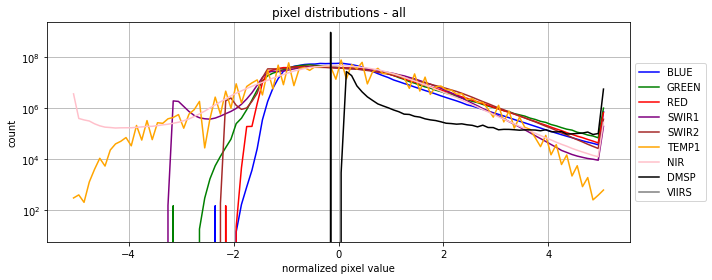

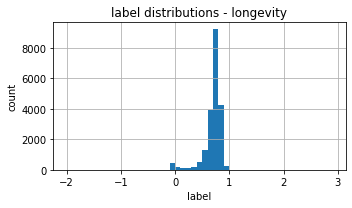

In [11]:
band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
plot_band_hists(
    band_hists,
    BAND_ORDER_NLSPLIT,
    band_colors=BAND_COLORS,
    bin_centers=BAND_BIN_CENTERS,
    xlabel='normalized pixel value',
    ylabel='count',
    title='pixel distributions - all',
    yscale='log')
plot_label_hist(
    labels=labels,
    bin_edges=LABEL_BIN_EDGES,
    title=f'label distributions - {LABEL_NAME}',
    figsize=(5, 3))

# Load folds

## Incountry folds + loc_dict

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [12]:
with open('/root/Datasets/SelectedClusters/dhs_incountry_co.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
    print(incountry_folds)

with open(f'/root/Datasets/SelectedClusters/loc_dict_brazil_2010_{LABEL_NAME}.pkl', 'rb') as f:
    loc_dict = pickle.load(f)
    

incountry_group_labels = np.zeros_like(labels, dtype=np.int32)
for i, f in enumerate(FOLDS):
    test_indices = incountry_folds[f]['test']
    incountry_group_labels[test_indices] = i

{'A': {'test': array([    1,     2,     3, ..., 20433, 20434, 20437]), 'val': array([   22,    23,    42, ..., 20414, 20416, 20424]), 'train': array([    0,     4,     5, ..., 20432, 20435, 20436])}, 'B': {'test': array([   22,    23,    42, ..., 20414, 20416, 20424]), 'val': array([    0,     4,     5, ..., 20418, 20419, 20429]), 'train': array([    1,     2,     3, ..., 20435, 20436, 20437])}, 'C': {'test': array([    0,     4,     5, ..., 20418, 20419, 20429]), 'val': array([   27,    29,    32, ..., 20423, 20435, 20436]), 'train': array([    1,     2,     3, ..., 20433, 20434, 20437])}, 'D': {'test': array([   27,    29,    32, ..., 20423, 20435, 20436]), 'val': array([   13,    14,    30, ..., 20426, 20431, 20432]), 'train': array([    0,     1,     2, ..., 20433, 20434, 20437])}, 'E': {'test': array([   13,    14,    30, ..., 20426, 20431, 20432]), 'val': array([    1,     2,     3, ..., 20433, 20434, 20437]), 'train': array([    0,     4,     5, ..., 20429, 20435, 20436])}}


## `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [13]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels
households = np.zeros(len(locs), dtype=np.int32)  # np.array of household counts

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)
#values = ["angola", "benin", "malawi"]


values=["brazil"]

for i, country in enumerate(values):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i
    print(country)
    
   

brazil


## Urban v. Rural

In [14]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, (lat, lon) => dict

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 'RURAL':
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print(f'num urban: {len(urban_indices)}\t num rural: {len(rural_indices)}')
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 438	 num rural: 20000


# Dumb Baseline Models

## Incountry: predict country mean

In [15]:
values=["brazil"]

mean_preds = np.zeros_like(labels)
for i, country in enumerate(values):
    indices = np.where(country_labels == i)[0]
    mean_preds[indices] = np.mean(labels[indices])
r2, _, _, _ = evaluate(labels, mean_preds, do_print=True)

r^2: nan, R^2: 0.000, mse: 0.028, rank: nan


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


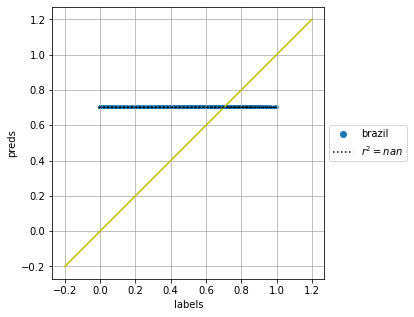

In [16]:
scatter_preds(labels, preds=mean_preds, by_name='country', by_col=np.asarray(values)[country_labels])

## Linear Nightlights

In [17]:
def linear_nl():
    linear_nl_df = pd.DataFrame(columns=['sensor', 'nl_type', 'weighted', 'r2'])
    linear_nl_df.set_index(['sensor', 'nl_type', 'weighted'], inplace=True)

    for sensor, mask in [('dmsp', dmsp_mask)]:
        for nl_type, nls in [('center', nls_center), ('mean', nls_mean)]:
            for weighted, w in [(False, None), (True, households)]:
                if weighted:
                    w = w[mask]
                linear_nl_df.loc[(sensor, nl_type, weighted)] = calc_score(
                    labels[mask], nls[mask], metric='r2', weights=w)
    display(linear_nl_df)

linear_nl()

ZeroDivisionError: Weights sum to zero, can't be normalized

## KNN on Nightlights

The following section uses leave-one-fold-out CV. This is fine for "incountry" training, but is different from the leave-one-country-out CV used for our other OOC training. For the leave-one-country-out OOC results, see the section "KNN on Histograms" below.

In [18]:
def knn_nl_scalar(labels, years, nls_center, train_idxs, test_idxs, k=5):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls_center: np.array, shape [N]
    - splits: dict, split (str) => np.array
    - k: int, k for KNN
    '''
    train_nls = nls_center[train_idxs]

    # test
    test_nls = nls_center[test_idxs]
  
    test_labels = labels[test_idxs]
  
    preds = np.zeros_like(test_labels)
    knn_dmsp = sklearn.neighbors.KNeighborsRegressor(k)
    knn_viirs = sklearn.neighbors.KNeighborsRegressor(k)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for mask, model in [(dmsp_mask, knn_dmsp)]:
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, knn_dmsp, knn_viirs

In [19]:
def knn_cv_wrapper(labels, years, nls, folds, keep=1.0, seed=None, savepath=None, verbose=False):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices
    - keep: float, fraction of training and validation data to use
    - seed: int, random seed
    - savepath: str, path to save predictions
    - verbose: bool, whether to print out validation performance on each fold

    Returns
    - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
        best models from the last fold
    - test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    - savepath: str, path to save npz file
    '''
    N = len(labels)
    assert len(years) == N
    assert len(nls) == N
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    fold_keys = sorted(folds.keys())
    r2s = np.zeros([len(fold_keys), len(ks)])
    R2s = np.zeros([len(fold_keys), len(ks)])

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for i, f in enumerate(fold_keys):
        if verbose:
            print(f'Runing fold {f}...')
        test_idxs = folds[f]['test']
        best_models = None

        for j, k in enumerate(ks):
            train_idxs = folds[f]['train']
            val_idxs = folds[f]['val']

            if keep < 1:
                if seed is not None:
                    np.random.seed(seed)
                num_train = int(len(train_idxs) * keep)
                num_val = int(len(val_idxs) * keep)
                if num_train < k or num_val < k:
                    continue
                train_idxs = np.random.choice(
                    train_idxs, size=num_train, replace=False)
                val_tfrecord_paths = np.random.choice(
                    val_idxs, size=num_val, replace=False)

            val_preds, knn_dmsp, knn_viirs = knn_nl_scalar(
                labels, years, nls, train_idxs=train_idxs,
                test_idxs=val_idxs, k=k)
                
            r2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='r2')
            R2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='R2')
            if R2 > np.max(R2s[i]):
                best_models = (knn_dmsp, knn_viirs)
            r2s[i, j], R2s[i, j] = r2, R2
            if verbose:
                print(f'fold={f}, k={k:4d}, val_r2={r2:0.4f}, val_R2={R2:0.4f}')

        for i, mask in enumerate([dmsp_mask]):
            subset_indices = np.intersect1d(np.nonzero(mask)[0], test_idxs)
            test_preds[subset_indices] = best_models[i].predict(nls[subset_indices].reshape(-1, 1))

    evaluate(labels=labels, preds=test_preds, do_print=True, title='test preds')

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, ks, r2s, R2s

def plot_knn_val_performance(nl_result, labels, title):
    '''
    Args
    - nl_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array
    - title: str
    '''
    _, test_preds, ks, r2s, R2s = nl_result
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    for i, f in enumerate(FOLDS):
        print(f'fold {f}, chosen k:', ks[np.argmax(R2s[i])])
        axs[0].plot(ks, r2s[i], label=f'fold={f}, $r^2$')
        axs[1].plot(ks, R2s[i], label=f'fold={f}, $R^2$')
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set(xlabel='k', xscale='log')
    axs[0].set(ylabel='score')
    fig.suptitle(f'{title} validation KNN performance vs. K', y=1.02)
    fig.tight_layout()
    plt.show()

def plot_knn_test(nls_center_result, nls_mean_result, labels,
                  nl0_center_mask, nl0_mean_mask, title):
    '''
    Args
    - *_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array, shape [N]
    - *_mask: np.array, shape [N]
    - title: str
    '''
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    results = [nls_center_result, nls_mean_result]
    nl0_masks = [nl0_center_mask, nl0_mean_mask]
    for result, nl0_mask, ax in zip(results, nl0_masks, axs):
        _, test_preds, ks, r2s, R2s = result
        scatter_preds(labels, test_preds, ax=ax)
        ax.scatter(x=labels[nl0_mask], y=test_preds[nl0_mask], c='red', s=2, label='NL = 0')
        ax.legend()
    axs[0].set_title(f'KNN on NL Center ({title})')
    axs[1].set_title(f'KNN on NL Mean ({title})')
    fig.tight_layout()
    plt.show()

In [20]:
def knn_wrapper_single(labels, years, nls, folds):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices

    Returns
    - best_model: sklearn.neighbors.KNeighborsRegressor
    - best_test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    '''
    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    r2s = np.zeros(len(ks))
    R2s = np.zeros(len(ks))
    best_test_preds = None

    for i, k in enumerate(ks):
        for f in FOLDS:
            print(f)
            train_idxs = np.concatenate([folds[f]['train'], folds[f]['val']])
            test_idxs = folds[f]['test']
            preds, model = knn_nl(labels, years, nls, k=k, train_idxs=train_idxs, test_idxs=test_idxs)
            test_preds[test_idxs] = preds

        print(f'k={k}, overall - ', end='')
        r2, R2, _, _ = evaluate(labels=labels, preds=test_preds, do_print=True)
        if r2 > np.max(r2s):
            best_test_preds = np.array(test_preds)  # make a copy
            best_model = model
        r2s[i], R2s[i] = r2, R2

    return best_model, best_test_preds, ks, r2s, R2s

In [21]:
DMSP0 = -MEANS['DMSP'] / STD_DEVS['DMSP']
nl0_center_mask = dmsp_mask
nl0_mean_mask = dmsp_mask

### Incountry

In [23]:
print(LOGS_ROOT_DIR)

/root/logs/longevity


In [24]:
nls_center_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_center, folds=incountry_folds,
    savepath= LOGS_ROOT_DIR + '/dhs_knn/' +  'incountry_nls_center/' + 'test_preds.npz')

nls_mean_result = knn_cv_wrapper(
    labels=labels, years=years, nls=nls_mean, folds=incountry_folds,
    savepath=LOGS_ROOT_DIR + '/dhs_knn/' +  'incountry_nls_mean/' + 'test_preds.npz')

test preds	- r^2: 0.006, R^2: 0.006, mse: 0.028, rank: 0.039
test preds	- r^2: 0.020, R^2: 0.020, mse: 0.027, rank: 0.144


fold A, chosen k: 500
fold B, chosen k: 500
fold C, chosen k: 30
fold D, chosen k: 500
fold E, chosen k: 200


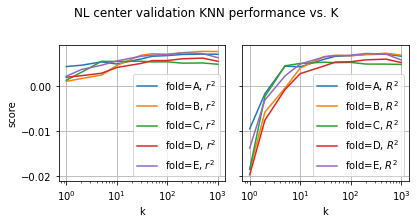

fold A, chosen k: 200
fold B, chosen k: 200
fold C, chosen k: 100
fold D, chosen k: 200
fold E, chosen k: 200


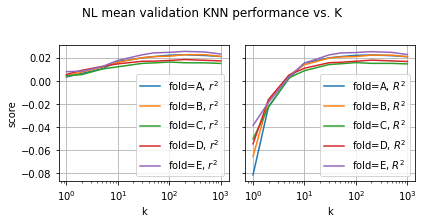

In [25]:
plot_knn_val_performance(nls_center_result, labels, title='NL center')
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

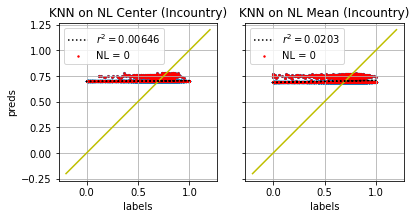

In [26]:
plot_knn_test(nls_center_result, nls_mean_result, labels,
              nl0_center_mask, nl0_mean_mask, title='Incountry')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


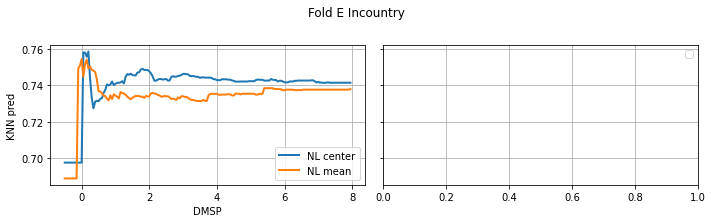

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for result, title in [(nls_center_result, 'NL center'),
                      (nls_mean_result, 'NL mean')]:
    models = result[0]
    masks = [dmsp_mask]
    for i in range(1):
        ax, mask, model = axs[i], masks[i], models[i]
        nls = np.arange(-0.5, 8, 0.05)
        preds = model.predict(nls.reshape(-1, 1))
        ax.plot(nls, preds, linewidth=2, label=title)

axs[0].set(xlabel='DMSP', ylabel='KNN pred')

for ax in axs:
    ax.grid(True)
    ax.legend()
fig.suptitle('Fold E Incountry', y=1.02)
fig.tight_layout()
plt.show()

## GBT on NL

As with the KNN section above, this section uses leave-one-fold-out OOC training, which is not directly comparable to our other leave-one-country-out OOC results.

In [28]:
def gbt_nl(labels, years, nls_center, train_idxs, test_idxs, max_depth, lr):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls_center: np.array, shape [N]
    - splits: dict, split (str) => np.array
    - max_depth: int
    - lr: float, learning rate
    '''
    train_nls = nls_center[train_idxs]

    # test
    test_nls = nls_center[test_idxs]
    test_labels = labels[test_idxs]
    preds = np.zeros_like(test_labels)

    params = {
        'n_estimators': 50,
        'max_depth': max_depth,
        'min_samples_split': 2,
        'learning_rate': lr,
        'loss': 'ls'
    }
    gbt_dmsp = sklearn.ensemble.GradientBoostingRegressor(**params)
    gbt_viirs = sklearn.ensemble.GradientBoostingRegressor(**params)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for mask, model in [(dmsp_mask, gbt_dmsp)]:
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, gbt_dmsp, gbt_viirs

In [29]:
def gbt_cv_wrapper(labels, years, nls, folds, keep=1.0, seed=None, savepath=None, verbose=False):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices
    - keep: float, fraction of training and validation data to use
    - seed: int, random seed
    - savepath: str, path to save predictions
    - verbose: bool, whether to print out validation performance on each fold

    Returns
    - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
        best models from the last fold
    - test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    - savepath: str, path to save npz file
    '''
    N = len(labels)
    assert len(years) == N
    assert len(nls) == N
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)
    max_depths = [2, 3, 4, 5, 6]
    lrs = [5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
    fold_keys = sorted(folds.keys())
    print(fold_keys)
    r2s = np.zeros([len(fold_keys), len(max_depths), len(lrs)])
    R2s = np.zeros([len(fold_keys), len(max_depths), len(lrs)])

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for i, f in enumerate(fold_keys):
        if verbose:
            print(f'Runing fold {f}...')
        test_idxs = folds[f]['test']
        best_models = None

        for j, d in enumerate(max_depths):
            for k, lr in enumerate(lrs):
                train_idxs = folds[f]['train']
                val_idxs = folds[f]['val']

                if keep < 1:
                    if seed is not None:
                        np.random.seed(seed)
                    num_train = int(len(train_idxs) * keep)
                    num_val = int(len(val_idxs) * keep)
                    if num_train < k or num_val < k:
                        continue
                    train_idxs = np.random.choice(
                        train_idxs, size=num_train, replace=False)
                    val_tfrecord_paths = np.random.choice(
                        val_idxs, size=num_val, replace=False)

                val_preds, gbt_dmsp, gbt_viirs = gbt_nl(
                    labels, years, nls, train_idxs=train_idxs,
                    test_idxs=val_idxs, max_depth=d, lr=lr)
                r2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='r2')
                R2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='R2')
                if R2 > np.max(R2s[i]):
                    best_models = (gbt_dmsp, gbt_viirs)
                r2s[i, j, k], R2s[i, j, k] = r2, R2
                if verbose:
                    print(f'fold={f}, depth={d:4d}, lr={lr:0.4f} val_r2={r2:0.4f}, val_R2={R2:0.4f}')

        for i, mask in enumerate([dmsp_mask]):
            subset_indices = np.intersect1d(np.nonzero(mask)[0], test_idxs)
            test_preds[subset_indices] = best_models[i].predict(nls[subset_indices].reshape(-1, 1))

    evaluate(labels=labels, preds=test_preds, do_print=True, title='test preds')

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, max_depths, lrs, r2s, R2s

def plot_depth_v_lr(depths, lrs, r2s, folds, title=None):
    '''
    Args
    - depths: list of int, length num_depths
    - lrs: list of float, length num_lrs
    - r2s: np.array, shape [num_folds, num_depths, num_lrs]
    - folds: list of str, names of folds
    - title: str
    '''
    lrs, depths = np.meshgrid(lrs, depths)
    lrs = lrs.flatten()
    depths = depths.flatten()

    vmin, vmax = r2s.min(), r2s.max()

    fig, axs = plt.subplots(nrows=1, ncols=len(folds), figsize=[10, 3])
    for i, ax in enumerate(axs):
        f = folds[i]
        j, k = np.nonzero(r2s[i] == np.max(r2s[i]))
        j, k = j[0], k[0]
        d = depths[j]
        lr = lrs[k]
        print(f'fold {f}, chosen depth: {d}, lr: {lr}')
        cax = ax.scatter(x=lrs, y=depths, s=30, c=r2s[i].flatten(), vmin=vmin, vmax=vmax)
        ax.set_title(f'{title}, Fold {f} r^2')

    for ax in axs:
        ax.set_xscale('log')
        ax.set_xlim(left=np.min(lrs)/2, right=np.max(lrs)*2)
        ax.set_xlabel('learning_rate')
        ax.set_ylabel('max_depth')
        ax.grid(True)

    cbar = fig.colorbar(cax)
    fig.tight_layout()
    plt.show()

# Ridge Regression on Histograms

- set "missing" DMSP and VIIRS values to 0 (i.e. the mean)
- not sure if this is the most "correct" thing to do, but it's somewhat reasonable approximation

In [31]:
# standardize to 0 mean and unit variance
num_examples = len(image_hists)
image_hists_mean = np.mean(image_hists, axis=0, dtype=np.float64)
image_hists_std = np.std(image_hists, axis=0, dtype=np.float64)

image_hists_mean[7] = np.mean(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
#image_hists_mean[8] = np.mean(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

image_hists_std[7] = np.std(image_hists[dmsp_mask, 7], axis=0, dtype=np.float64)
#image_hists_std[8] = np.std(image_hists[viirs_mask, 8], axis=0, dtype=np.float64)

standardized_image_hists = np.zeros(image_hists.shape, dtype=np.float64)
for mask in [dmsp_mask, viirs_mask]:
    standardized_image_hists[mask] = (image_hists[mask] - image_hists_mean) / (image_hists_std + 1e-6)

print(standardized_image_hists.shape)

(20438, 9, 102)


In [32]:
def split_nls(nls, years):
    '''
    Args
    - nls: np.array, shape [N]
    - years: np.array, shape [N]

    Returns
    - nls_split: np.array, shape [N, 2]
    '''
    N = len(nls)
    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask
    nls_split = np.zeros([N, 2], dtype=np.float32)
    nls_split[dmsp_mask, 0] = nls[dmsp_mask]
    nls_split[viirs_mask, 1] = nls[viirs_mask]
    return nls_split

In [33]:
standardized_nls_center = split_nls(nls_center, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    standardized_nls_center[mask, i] -= np.mean(standardized_nls_center[mask, i])
    standardized_nls_center[mask, i] -= np.std(standardized_nls_center[mask, i])

standardized_nls_mean = split_nls(nls_mean, years)
for i, mask in enumerate([dmsp_mask, viirs_mask]):
    standardized_nls_mean[mask, i] -= np.mean(standardized_nls_mean[mask, i])
    standardized_nls_mean[mask, i] -= np.std(standardized_nls_mean[mask, i])

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Incountry

In [34]:
def ridge_incountry_wrapper(img_hists, model_name):
    print(model_name)
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name))
    print(f'== {model_name} urban ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=urban_indices, subset_name='urban')
    print(f'== {model_name} rural ==')
    ridge_cv(
        features=img_hists.reshape(num_examples, -1), labels=labels,
        group_labels=incountry_group_labels, group_names=FOLDS,
        savedir=os.path.join(LOGS_ROOT_DIR, 'dhs_ridge', model_name),
        subset_indices=rural_indices, subset_name='rural')

In [35]:
model_name = 'incountry_nlcenter_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_nls_center)

incountry_nlcenter_scalar
Group: A
best val mse: 0.028, best alpha: 1024.0, test mse: 0.027
Group: B
best val mse: 0.028, best alpha: 1024.0, test mse: 0.028
Group: C
best val mse: 0.027, best alpha: 128.0, test mse: 0.029
Group: D
best val mse: 0.027, best alpha: 1024.0, test mse: 0.028
Group: E
best val mse: 0.028, best alpha: 1024.0, test mse: 0.026
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nlcenter_scalar/test_preds.npz
== incountry_nlcenter_scalar urban ==
Group: A
best val mse: 0.009, best alpha: 1024.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 1024.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 128.0, test mse: 0.011
Group: D
best val mse: 0.007, best alpha: 1024.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 1024.0, test mse: 0.004
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nlcenter_scalar/test_preds_urban.npz
== incountry_nlcenter_scalar rural ==
Group: A
best val mse: 0.028, best alpha: 16.0

In [36]:
model_name = 'incountry_nlmean_scalar'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_nls_mean)

incountry_nlmean_scalar
Group: A
best val mse: 0.028, best alpha: 1024.0, test mse: 0.027
Group: B
best val mse: 0.028, best alpha: 1024.0, test mse: 0.028
Group: C
best val mse: 0.027, best alpha: 128.0, test mse: 0.029
Group: D
best val mse: 0.027, best alpha: 1024.0, test mse: 0.028
Group: E
best val mse: 0.028, best alpha: 1024.0, test mse: 0.026
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nlmean_scalar/test_preds.npz
== incountry_nlmean_scalar urban ==
Group: A
best val mse: 0.009, best alpha: 1024.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 1024.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 1024.0, test mse: 0.011
Group: D
best val mse: 0.007, best alpha: 1024.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 1024.0, test mse: 0.004
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nlmean_scalar/test_preds_urban.npz
== incountry_nlmean_scalar rural ==
Group: A
best val mse: 0.028, best alpha: 128.0, test m

In [37]:
model_name = 'incountry_rgb_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :3, :])

incountry_rgb_hist
Group: A
best val mse: 0.026, best alpha: 1024.0, test mse: 0.024
Group: B
best val mse: 0.026, best alpha: 1024.0, test mse: 0.026
Group: C
best val mse: 0.025, best alpha: 1024.0, test mse: 0.027
Group: D
best val mse: 0.026, best alpha: 1024.0, test mse: 0.026
Group: E
best val mse: 0.026, best alpha: 1024.0, test mse: 0.024
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_rgb_hist/test_preds.npz
== incountry_rgb_hist urban ==
Group: A
best val mse: 0.009, best alpha: 65536.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 8192.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 8192.0, test mse: 0.012
Group: D
best val mse: 0.007, best alpha: 8192.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 8192.0, test mse: 0.004
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_rgb_hist/test_preds_urban.npz
== incountry_rgb_hist rural ==
Group: A
best val mse: 0.026, best alpha: 1024.0, test mse: 0.025
Group: B
bes

In [38]:
model_name = 'incountry_rgbnl_hist'
bands = [0, 1, 2, -2, -1]
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, bands, :])

incountry_rgbnl_hist
Group: A
best val mse: 0.026, best alpha: 1024.0, test mse: 0.024
Group: B
best val mse: 0.025, best alpha: 1024.0, test mse: 0.026
Group: C
best val mse: 0.025, best alpha: 1024.0, test mse: 0.027
Group: D
best val mse: 0.025, best alpha: 1024.0, test mse: 0.026
Group: E
best val mse: 0.026, best alpha: 1024.0, test mse: 0.024
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_rgbnl_hist/test_preds.npz
== incountry_rgbnl_hist urban ==
Group: A
best val mse: 0.009, best alpha: 65536.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 524288.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 65536.0, test mse: 0.011
Group: D
best val mse: 0.007, best alpha: 65536.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 8192.0, test mse: 0.005
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_rgbnl_hist/test_preds_urban.npz
== incountry_rgbnl_hist rural ==
Group: A
best val mse: 0.026, best alpha: 1024.0, test mse: 0.02

In [39]:
model_name = 'incountry_ms_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, :7, :])

incountry_ms_hist
Group: A
best val mse: 0.025, best alpha: 1024.0, test mse: 0.024
Group: B
best val mse: 0.025, best alpha: 1024.0, test mse: 0.025
Group: C
best val mse: 0.024, best alpha: 1024.0, test mse: 0.026
Group: D
best val mse: 0.025, best alpha: 1024.0, test mse: 0.025
Group: E
best val mse: 0.025, best alpha: 1024.0, test mse: 0.023
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_ms_hist/test_preds.npz
== incountry_ms_hist urban ==
Group: A
best val mse: 0.009, best alpha: 8192.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 65536.0, test mse: 0.009
Group: C
best val mse: 0.006, best alpha: 1024.0, test mse: 0.012
Group: D
best val mse: 0.007, best alpha: 65536.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 8192.0, test mse: 0.004
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_ms_hist/test_preds_urban.npz
== incountry_ms_hist rural ==
Group: A
best val mse: 0.025, best alpha: 1024.0, test mse: 0.024
Group: B
best va

In [40]:
model_name = 'incountry_msnl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists)

incountry_msnl_hist
Group: A
best val mse: 0.025, best alpha: 1024.0, test mse: 0.024
Group: B
best val mse: 0.025, best alpha: 1024.0, test mse: 0.025
Group: C
best val mse: 0.024, best alpha: 1024.0, test mse: 0.026
Group: D
best val mse: 0.025, best alpha: 1024.0, test mse: 0.025
Group: E
best val mse: 0.025, best alpha: 1024.0, test mse: 0.023
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_msnl_hist/test_preds.npz
== incountry_msnl_hist urban ==
Group: A
best val mse: 0.009, best alpha: 8192.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 524288.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 65536.0, test mse: 0.012
Group: D
best val mse: 0.007, best alpha: 65536.0, test mse: 0.009
Group: E
best val mse: 0.008, best alpha: 8192.0, test mse: 0.005
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_msnl_hist/test_preds_urban.npz
== incountry_msnl_hist rural ==
Group: A
best val mse: 0.025, best alpha: 1024.0, test mse: 0.024
Grou

In [41]:
model_name = 'incountry_nl_hist'
ridge_incountry_wrapper(model_name=model_name, img_hists=standardized_image_hists[:, -2:, :])

incountry_nl_hist
Group: A
best val mse: 0.028, best alpha: 1024.0, test mse: 0.026
Group: B
best val mse: 0.027, best alpha: 1024.0, test mse: 0.028
Group: C
best val mse: 0.027, best alpha: 1024.0, test mse: 0.029
Group: D
best val mse: 0.027, best alpha: 1024.0, test mse: 0.028
Group: E
best val mse: 0.028, best alpha: 1024.0, test mse: 0.026
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nl_hist/test_preds.npz
== incountry_nl_hist urban ==
Group: A
best val mse: 0.009, best alpha: 524288.0, test mse: 0.003
Group: B
best val mse: 0.007, best alpha: 17179869184.0, test mse: 0.009
Group: C
best val mse: 0.007, best alpha: 17179869184.0, test mse: 0.012
Group: D
best val mse: 0.007, best alpha: 17179869184.0, test mse: 0.010
Group: E
best val mse: 0.008, best alpha: 8192.0, test mse: 0.005
saving test preds to: /root/logs/longevity/dhs_ridge/incountry_nl_hist/test_preds_urban.npz
== incountry_nl_hist rural ==
Group: A
best val mse: 0.028, best alpha: 1024.0, test mse: 0

In [42]:
COUNTRIES=["brazil"]

# KNN on Histograms

## Incountry

In [43]:
def knn_incountry_wrapper(img_hists, model_name, years=None):
    savedir = os.path.join(LOGS_ROOT_DIR, 'dhs_knn', model_name)
    features = img_hists.reshape(len(img_hists), -1)

    print(model_name)
    if years is None:
        knn_cv_opt(features=features, labels=labels,
                   group_labels=incountry_group_labels, group_names=FOLDS,
                   savedir=savedir)
    else:  # split DMSP and VIIRS
        filename = 'test_preds.npz'
        npz_path = os.path.join(savedir, filename)
        # assert not os.path.exists(npz_path)

        dmsp_mask = years < 2012
        viirs_mask = ~dmsp_mask
        test_preds = np.zeros(len(image_hists), dtype=np.float32)
        for mask in [dmsp_mask]:
            test_preds[mask] = knn_cv_opt(
                features=features[mask], labels=labels[mask],
                group_labels=incountry_group_labels[mask], group_names=FOLDS)

        os.makedirs(savedir, exist_ok=True)
        save_dict = {
            'labels': labels,
            'test_preds': test_preds
        }
        print('saving test preds to:', npz_path)
        np.savez_compressed(npz_path, **save_dict)

        evaluate(labels=labels, preds=test_preds, do_print=True,
                 title='DMSP and VIIRS test preds')

In [44]:
model_name = 'incountry_nlcenter_scalar'
knn_incountry_wrapper(model_name=model_name, img_hists=nls_center, years=years)

incountry_nlcenter_scalar
Pre-computing distance matrix... took 3.48 seconds.
Group: A
best val mse: 0.028, best k: 1024, test mse: 0.026
Group: B
best val mse: 0.028, best k: 1024, test mse: 0.028
Group: C
best val mse: 0.027, best k: 1024, test mse: 0.029
Group: D
best val mse: 0.027, best k: 1024, test mse: 0.028
Group: E
best val mse: 0.028, best k: 512, test mse: 0.026
Pooled test preds	- r^2: 0.005, R^2: 0.005, mse: 0.028, rank: 0.036
saving test preds to: /root/logs/longevity/dhs_knn/incountry_nlcenter_scalar/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.005, R^2: 0.005, mse: 0.028, rank: 0.036


In [45]:
model_name = 'incountry_nlmean_scalar'
knn_incountry_wrapper(model_name=model_name, img_hists=nls_mean, years=years)

incountry_nlmean_scalar
Pre-computing distance matrix... took 3.50 seconds.
Group: A
best val mse: 0.027, best k: 512, test mse: 0.026
Group: B
best val mse: 0.027, best k: 512, test mse: 0.027
Group: C
best val mse: 0.027, best k: 256, test mse: 0.029
Group: D
best val mse: 0.027, best k: 128, test mse: 0.028
Group: E
best val mse: 0.028, best k: 1024, test mse: 0.026
Pooled test preds	- r^2: 0.020, R^2: 0.020, mse: 0.027, rank: 0.115
saving test preds to: /root/logs/longevity/dhs_knn/incountry_nlmean_scalar/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.020, R^2: 0.020, mse: 0.027, rank: 0.115


In [46]:
model_name = 'incountry_nl_hist'
knn_incountry_wrapper(model_name=model_name, img_hists=image_hists[:, -2:, :], years=years)

incountry_nl_hist
Pre-computing distance matrix... took 26.40 seconds.
Group: A
best val mse: 0.027, best k: 512, test mse: 0.026
Group: B
best val mse: 0.027, best k: 256, test mse: 0.027
Group: C
best val mse: 0.027, best k: 256, test mse: 0.029
Group: D
best val mse: 0.027, best k: 512, test mse: 0.028
Group: E
best val mse: 0.027, best k: 512, test mse: 0.026
Pooled test preds	- r^2: 0.020, R^2: 0.020, mse: 0.027, rank: 0.111
saving test preds to: /root/logs/longevity/dhs_knn/incountry_nl_hist/test_preds.npz
DMSP and VIIRS test preds	- r^2: 0.020, R^2: 0.020, mse: 0.027, rank: 0.111
